In [162]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from GCE.pdf_sampler import PDFSampler

# Rescale font sizes
rs = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25*rs
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22*rs
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22*rs
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
# Nick's code for the dNdF
def dNdF(F, A, Fb, n1, n2):
    if F >= Fb:
        return A * (F / Fb) ** (-n1)
    else:
        return A * (F / Fb) ** (-n2)


dNdF = np.vectorize(dNdF)


def CDF(F, Fb, n1, n2):
    if F < Fb:
        return (n1 - 1.) / (n1 - n2) * (F / Fb) ** (1. - n2)
    else:
        return 1. - (1. - n2) / (n1 - n2) * (F / Fb) ** (1. - n1)


CDF = np.vectorize(CDF)

In [164]:
# Parameters
Ag = np.array([8.e10, 8.5e9, 3.1e12])
Fbg = np.array([2.e-11, 1.e-10, 1.e-12])
n1g = np.array([2.06, 2.8, 1.9])
n2g = np.array([-0.5, -0.1, -1.7])
N_tot = Ag * Fbg * (1 / (n1g - 1) + 1 / (1 - n2g))

In [165]:
i = 2  # only look at one set of parameters

In [166]:
# Simulate a "NN-like analysis"
bins_dndf = np.asarray([-np.infty] + list(np.logspace(-12.5, -7.0, 21)) + [np.infty])  # bins for SCD

dlogF = np.diff(np.log10(bins_dndf))[1]
bins_ext = np.copy(bins_dndf) 
bins_ext[0] = 10 ** (np.log10(bins_ext[1]) - dlogF)
bins_ext[-1] = 10 ** (np.log10(bins_ext[-2]) + dlogF)
bin_centers = 10 ** (np.log10(bins_ext[:-1]) + np.diff(np.log10(bins_ext)) / 2)

power_of_f_dndf = 1.0
n_ps = 100000

/tmp/ipykernel_79262/2818690755.py:4: RuntimeWarning: invalid value encountered in log10
  dlogF = np.diff(np.log10(bins_dndf))[1]


In [167]:
print(bin_centers)

[2.30409298e-13 4.34010264e-13 8.17523038e-13 1.53992653e-12
 2.90068120e-12 5.46386550e-12 1.02920053e-11 1.93865264e-11
 3.65174127e-11 6.87859912e-11 1.29568670e-10 2.44061907e-10
 4.59726989e-10 8.65964323e-10 1.63117291e-09 3.07255737e-09
 5.78761988e-09 1.09018449e-08 2.05352503e-08 3.86812055e-08
 7.28618175e-08 1.37246096e-07]


In [168]:
# Sample point-sources from the dNdF
fvals = np.logspace(-12.5, -9.0, 1000)
sampler = PDFSampler(fvals, dNdF(fvals, Ag[i], Fbg[i], n1g[i], n2g[i]))
samples = sampler(n_ps)

In [169]:
# Evaluate the true PDF
true_integral = np.trapz(dNdF(fvals, Ag[i], Fbg[i], n1g[i], n2g[i]) / N_tot[i], fvals)
true_pdf = dNdF(fvals, Ag[i], Fbg[i], n1g[i], n2g[i]) / N_tot[i]
print("True integral on fine grid: ", true_integral)

True integral on fine grid:  0.9873442514188882


In [170]:
# Do the same, but at the bin centers
true_pdf_at_bin_centers = dNdF(bin_centers, Ag[i], Fbg[i], n1g[i], n2g[i]) / N_tot[i]
true_integral_at_bin_centers = np.trapz(true_pdf_at_bin_centers, bin_centers)
print("True integral at bin centers: ", true_integral_at_bin_centers)

True integral at bin centers:  1.0311874715128464


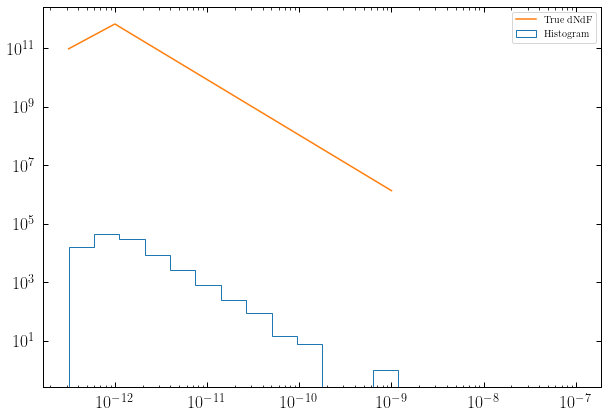

In [171]:
# Plot
plt.figure(figsize=(10, 7))
plt.hist(samples, bins=bins_dndf, histtype='step', weights=np.ones_like(samples), label="Histogram")
plt.plot(fvals, true_pdf, label="True dNdF")
plt.legend()
plt.xscale("log")
plt.yscale("log")

In [172]:
# Now, generate a histogram in the way that I do it for the NN
flux_hist, bin_edges = np.histogram(samples, weights=samples ** power_of_f_dndf, bins=bins_dndf)

In [173]:
print("Sum of histogram: ", np.sum(flux_hist))
print("Sum of fluxes: ", np.sum(samples))

Sum of histogram:  1.4252103097767683e-07
Sum of fluxes:  1.425210309776806e-07


In [174]:
# Normalize the histogram
neural_network_hist = flux_hist / flux_hist.sum()
print("Sum of normalized histogram: ", np.sum(flux_hist))

Sum of normalized histogram:  1.4252103097767683e-07


## At this point, neural_network_hist is a histogram like those that I use in the NN. Let's now try to restore the dNdF from this histogram.

In [175]:
total_ps_flux = np.sum(samples)  # let's assume we perfectly know the total flux

In [176]:
# Restore the dNdF from flux_hist
dNdF_restored_step_1 = flux_hist * total_ps_flux  # Step 1) multiply by the total flux
dNdF_restored_step_2 = dNdF_restored_step_1 / np.diff(bin_edges)  # Step 2) divide by the bin width
dNdF_restored_integral = np.trapz(dNdF_restored_step_2, bin_centers)  # compute the integral of the restored dNdF
dNdF_restored_step_3 = dNdF_restored_step_2 / dNdF_restored_integral  # normalize the restored dNdF: now, it integrates to 1, BUT: should integrate to N!
reconstructed_flux = np.trapz(dNdF_restored_step_3 * bin_centers, bin_centers)  # compute the total flux

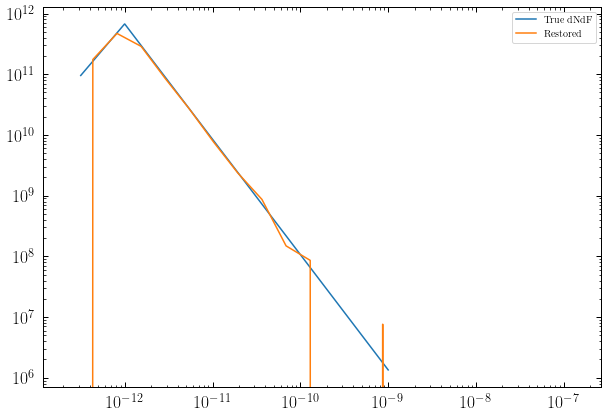

In [177]:
plt.figure(figsize=(10, 7))
plt.loglog(fvals, 1/N_tot[i]*dNdF(fvals, Ag[i], Fbg[i], n1g[i], n2g[i]), label="True dNdF")
plt.loglog(bin_centers, dNdF_restored_step_3, label="Restored")
plt.legend()